### Preparing data and queries

* Schema from [here](https://docs.verdictdb.org/documentation/step_by_step_tutorial/tpch_load_data/#postgresql)
* Data from [here](https://www.kaggle.com/datasets/davidalexander01/tpc-h-dataset), downloaded using  [download_data_from_kaggle.ipynb](download_data_from_kaggle.ipynb).
* Queries from [here](https://github.com/apache/doris/tree/master/tools/tpch-tools/queries)

We are not using any indexes.


Commands to create database and schema and load data:
```
createdb tpch
psql tpch -f schema/tpch_postgres.sdl 
psql tpch -f schema/tpch_load_data.sql

createdb tpch_columnar
psql tpch_columnar -f schema/tpch_postgres_columnar.sdl 
psql tpch_columnar -f schema/tpch_load_data.sql
```


In [1]:
import pandas as pd
import json
from diskcache import Cache
from matplotlib import pyplot as plt
import psycopg2
import time
import numpy as np

### Connecting to both databases

In [2]:
db_user = "postgres"
db_password = "admin"
db_host = "localhost"
db_port = 5432
db_name_1 = "tpch"
db_name_2 = "tpch_columnar"

conn1 = psycopg2.connect(f"dbname='{db_name_1}' user='{db_user}' host='{db_host}' password='{db_password}'")
conn2 = psycopg2.connect(f"dbname='{db_name_2}' user='{db_user}' host='{db_host}' password='{db_password}'")
print("OK")

OK


### Table sizes

In [8]:
sizes_query = """
SELECT tablename, pg_total_relation_size(quote_ident(tablename)) AS size
FROM pg_catalog.pg_tables
WHERE schemaname = 'public'
ORDER BY tablename
"""

with conn1.cursor() as cur:
    cur.execute(sizes_query)
    sizes1 = cur.fetchall()

with conn2.cursor() as cur:
    cur.execute(sizes_query)
    sizes2 = cur.fetchall()

sizes=[]
total_size_row = 0
total_size_col = 0
for i in range(len(sizes1)):
    assert sizes1[i][0]==sizes2[i][0]
    sizes.append([sizes1[i][0],sizes1[i][1],sizes2[i][1],sizes1[i][1]/sizes2[i][1]])
    total_size_row += sizes1[i][1]
    total_size_col += sizes2[i][1]
    
df=pd.DataFrame(sizes,columns=['Table name', 'Size in row-based (B)', 'Size in columnar (B)', 'Compresison ratio'])
df=df.style.hide(axis="index")
df
print(f"Total size, row-store: {total_size_row} B")
print(f"Total size, columnar: {total_size_col} B")
ratio = total_size_row / total_size_col
print(f"Ratio: {ratio:0.2f}")


Total size, row-store: 1406042112 B
Total size, columnar: 347332608 B
Ratio: 4.05


### Comparing query execution time

In [4]:
cache = Cache("~/db-experiments-cache/tpch")

@cache.memoize()
def run_experiment(query_path, store_type, run_id=0):
    # Returns query execution time in seconds.
    assert store_type in ["row", "columnar"]
    with open(query_path) as f:
        query = f.read()
    conn = conn1 if store_type == "row" else conn2
    print(f"{query_path} {store_type} run {run_id}...")
    t0=time.time()
    with conn.cursor() as cur:
        cur.execute(query)
        cur.fetchall()
    return time.time()-t0

# exclude 15 because uses view.
# exclude 17,20,21 because took too long (didn't complete in 10 minutes on row store).
query_ids = [i for i in range(1,23) if i not in [15,17,20,21]]

results = dict()
for query_id in query_ids:
    query_path = f'queries/tpch/q{query_id}.sql'
    for store_type in ['row', 'columnar']:
        res = [run_experiment(query_path, store_type, run_id=run_id) for run_id in range(5)]
        print(query_id, store_type, res)
        results[(query_id, store_type)] = res
#conn1.close()
#conn2.close()

1 row [1.6423466205596924, 1.4946517944335938, 1.4991366863250732, 1.5284442901611328, 1.5381207466125488]
1 columnar [3.747189998626709, 3.7691848278045654, 4.008178949356079, 4.075816869735718, 3.9940831661224365]
2 row [0.1928253173828125, 0.17086124420166016, 0.17116737365722656, 0.17249679565429688, 0.17937850952148438]
2 columnar [3.376575469970703, 3.068774938583374, 3.150393486022949, 3.145932912826538, 3.124988317489624]
3 row [0.37330031394958496, 0.3771679401397705, 0.38568115234375, 0.37727785110473633, 0.37059760093688965]
3 columnar [1.1294682025909424, 1.110684871673584, 1.0547330379486084, 1.0567851066589355, 1.0994155406951904]
4 row [0.5718660354614258, 0.5773630142211914, 0.5802891254425049, 0.577007532119751, 0.5723164081573486]
4 columnar [2.0210118293762207, 2.0108513832092285, 2.0127928256988525, 1.9988396167755127, 1.8648858070373535]
5 row [0.8669049739837646, 0.8191969394683838, 0.8233063220977783, 0.8254947662353516, 0.8316648006439209]
5 columnar [1.44472217

In [5]:
results_table = []
row_means, row_std = [], []
col_means, col_std = [], []
query_names=[]

for query_id in query_ids:
    query_name = f"Q{query_id}"
    mean_row, std_row = np.mean(results[(query_id, 'row')]), np.std(results[(query_id, 'row')])
    mean_col, std_col = np.mean(results[(query_id, 'columnar')]), np.std(results[(query_id, 'columnar')])    
    row_means.append(mean_row)
    row_std.append(std_row)
    col_means.append(mean_col)
    col_std.append(std_col)
    query_names.append(query_name)
    
    ratio = mean_row/mean_col
    results_table += [[
        query_name,
        f"{mean_row:0.1f}±{std_row:0.1f}",
        f"{mean_col:0.1f}±{std_col:0.1f}",
        f"{ratio:0.1f}"
    ]]

header=["Query", "Row-store time (sec)","Columnar time (sec)","Speedup"]
df=pd.DataFrame(results_table,columns=header)
df=df.style.hide(axis="index")
df

Query,Row-store time (sec),Columnar time (sec),Speedup
Q1,1.5±0.1,3.9±0.1,0.4
Q2,0.2±0.0,3.2±0.1,0.1
Q3,0.4±0.0,1.1±0.0,0.3
Q4,0.6±0.0,2.0±0.1,0.3
Q5,0.8±0.0,1.5±0.0,0.6
Q6,0.2±0.0,0.6±0.0,0.4
Q7,0.5±0.0,1.0±0.0,0.4
Q8,0.3±0.0,15.4±0.3,0.0
Q9,1.2±0.0,2.2±0.0,0.5
Q10,0.4±0.0,0.9±0.0,0.5


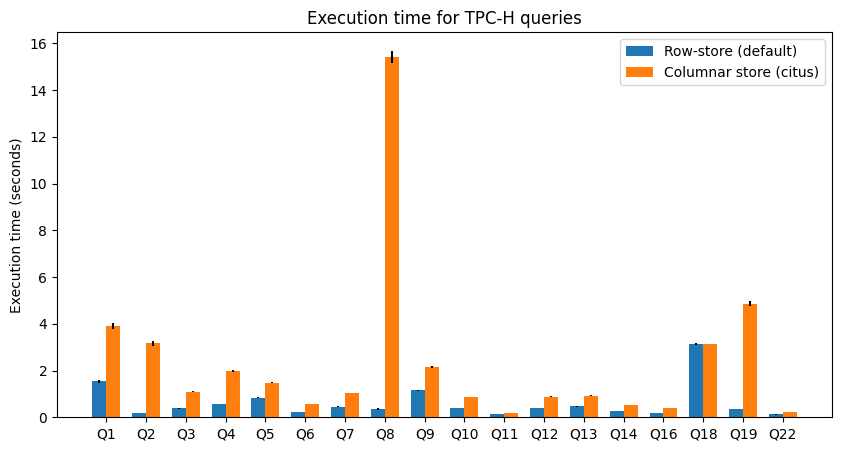

In [6]:
ind = np.arange(len(query_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(ind - width/2, row_means, width, yerr=row_std,
                label='Row-store (default)')
rects2 = ax.bar(ind + width/2, col_means, width, yerr=col_std,
                label='Columnar store (citus)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution time (seconds)')
ax.set_title('Execution time for TPC-H queries')
ax.set_xticks(ind)
ax.set_xticklabels(query_names)
ax.legend()
plt.savefig('img/results-tpch.png')
plt.show()